# 📊 Notebook 06: Training & Evaluating Baseline Model

## From Model to Metrics

This notebook teaches you how to train your neural network and evaluate its performance using standard classification metrics. You'll implement the training loop, compute accuracy and F1-scores, and analyze your baseline model's strengths and weaknesses.


## 🧠 Concept Primer: Training and Evaluation

### What We're Doing
Training your neural network to minimize loss and evaluating its performance on unseen data using classification metrics.

### Why This Step is Critical
**Training updates model weights** to learn patterns in the data. **Evaluation measures** how well the model generalizes to new examples.

### Training Loop Components
1. **Forward pass**: Input → Model → Predictions
2. **Loss computation**: Predictions vs true labels
3. **Backward pass**: Compute gradients
4. **Parameter update**: Adjust weights to reduce loss

### Evaluation Metrics
- **Accuracy**: Percentage of correct predictions
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)  
- **F1-Score**: Harmonic mean of precision and recall

### Shape Expectations
- **Logits**: `[batch, n_aspects]` → raw model outputs
- **Predictions**: `[batch]` → argmax of logits
- **Labels**: `[batch]` → true class indices


In [50]:
import torch
import torch.nn as nn
import pandas as pd
import re

# Comes from the previous notebooks
import pandas as pd
import re
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

def pad_or_truncate(sequence, max_len, padding_value=0):
    """
    Pads or truncates a sequence to a specified target length.

    Parameters:
    sequence (list): The input sequence to be padded or truncated.
    target_length (int): The desired length of the output sequence.
    padding_value (any): The value to use for padding if the sequence is shorter than the target length.

    Returns:
    list: The padded or truncated sequence.
    """
    if len(sequence) < max_len:
        # Pad the sequence
        return sequence + [padding_value] * (max_len - len(sequence))
    else:
        # Truncate the sequence
        return sequence[:max_len]

# Test the function
sample_sequence = [1, 2, 3]
padded_sequence = pad_or_truncate(sample_sequence, 5, padding_value=0)
truncated_sequence = pad_or_truncate(sample_sequence, 2)

def tokenize(text):
    # Use regex to find words, ignoring punctuation
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

train_reviews_df = pd.read_csv('../data/imdb_movie_reviews_train.csv')
test_reviews_df = pd.read_csv('../data/imdb_movie_reviews_test.csv')

tokenized_corpus_train = train_reviews_df['review'].apply(tokenize).tolist() 
tokenized_corpus_test = test_reviews_df['review'].apply(tokenize).tolist()

combined_corpus = [token for sublist in tokenized_corpus_train + tokenized_corpus_test for token in sublist]

word_freqs = Counter(combined_corpus)
print(word_freqs.most_common(10))

max_vocab_size = 1002
most_common_words = word_freqs.most_common(max_vocab_size - 2)  # Reserve 2 for <PAD> and <UNK>
vocab = {'<PAD>': 0, '<UNK>': 1, **{word: idx + 2 for idx, (word, _) in enumerate(most_common_words)}}
print(list(vocab.items())[:10])  # Print first 10 items in vocabulary dictionary
vocab_size = len(vocab)

def encode_text(text, vocab):
    tokens = tokenize(text)
    encoded = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return encoded

encoded_reviews_train = train_reviews_df['review'].apply(lambda x: encode_text(x, vocab)).tolist()
encoded_reviews_test = test_reviews_df['review'].apply(lambda x: encode_text(x, vocab)).tolist()

max_sequence_length = 128
padded_encoded_reviews_train = [pad_or_truncate(seq, max_sequence_length, padding_value=vocab['<PAD>']) for seq in encoded_reviews_train]
padded_encoded_reviews_test = [pad_or_truncate(seq, max_sequence_length, padding_value=vocab['<PAD>']) for seq in encoded_reviews_test]
X_tensor_train = torch.tensor(padded_encoded_reviews_train, dtype=torch.long)
X_tensor_test = torch.tensor(padded_encoded_reviews_test, dtype=torch.long)
y_tensor_train = torch.tensor(train_reviews_df['aspect_encoded'].values, dtype=torch.long)
y_tensor_test = torch.tensor(test_reviews_df['aspect_encoded'].values, dtype=torch.long)

batch_size = 16
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SimpleNN(nn.Module):
    def __init__(self, vocab_size, output_size,embed_size=50, hidden_size=100, pad_id=0):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_id)
        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.pad_id = pad_id
    
    def forward(self, x):
        embedded = self.embedding(x)  # [16, 128, 50]
        mask = (x != self.pad_id).unsqueeze(-1).float()  # [16, 128, 1]
        masked_embedded = embedded * mask  # [16, 128, 50]
        pooled = masked_embedded.sum(dim=1) / mask.sum(dim=1).clamp(min=1)  # [16, 50]


        x = self.fc1(pooled)
        x = self.relu(x)
        x = self.fc2(x)
        return x

n_aspects = 3

model = SimpleNN(vocab_size=len(vocab), output_size=n_aspects)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

[('the', 1009), ('a', 423), ('of', 405), ('and', 399), ('to', 295), ('is', 295), ('in', 235), ('it', 191), ('s', 147), ('that', 140)]
[('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('a', 3), ('of', 4), ('and', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9)]


## 🔧 TODO #1: Implement Training Loop

**Task:** Create training loop that iterates through batches and updates model parameters.

**Hint:** Use `model.train()`, then loop with `optimizer.zero_grad()`, forward pass, loss computation, `loss.backward()`, `optimizer.step()`

**Expected Function:**
```python
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        total_loss = 0
        # TODO: Training loop here
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
```

**Track:** Total loss per epoch to monitor training progress


In [51]:
# TODO #1: Implement training loop
# Your code here
n_epochs = 30

def train_model(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []  # ✅ Add this
    test_accuracies = []  # ✅ Add this
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # ✅ Evaluation phase (on test set)
        model.eval()
        test_epoch_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_epoch_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
        
        test_loss = test_epoch_loss / len(test_loader)
        test_acc = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")
    
    return train_losses, train_accuracies, test_losses, test_accuracies

## 🔧 TODO #2: Implement Evaluation Function

**Task:** Create evaluation function that computes predictions and metrics on test data.

**Hint:** Use `model.eval()`, `with torch.no_grad():`, collect predictions with `torch.argmax(torch.softmax(logits, dim=1), dim=1)`

**Expected Function:**
```python
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    # TODO: Evaluation loop here
    return all_predictions, all_labels
```

**Shape:** Predictions and labels should both be lists of integers


Epoch [1/30]
  Train - Loss: 1.0945, Acc: 0.3360
  Test  - Loss: 1.0925, Acc: 0.3561
Epoch [2/30]
  Train - Loss: 1.0928, Acc: 0.3442
  Test  - Loss: 1.0909, Acc: 0.3409
Epoch [3/30]
  Train - Loss: 1.0812, Acc: 0.3523
  Test  - Loss: 1.0892, Acc: 0.3561
Epoch [4/30]
  Train - Loss: 1.0741, Acc: 0.3767
  Test  - Loss: 1.0877, Acc: 0.3561
Epoch [5/30]
  Train - Loss: 1.0852, Acc: 0.3930
  Test  - Loss: 1.0859, Acc: 0.3712
Epoch [6/30]
  Train - Loss: 1.0788, Acc: 0.4065
  Test  - Loss: 1.0845, Acc: 0.3788
Epoch [7/30]
  Train - Loss: 1.0785, Acc: 0.4119
  Test  - Loss: 1.0836, Acc: 0.3788
Epoch [8/30]
  Train - Loss: 1.0785, Acc: 0.4255
  Test  - Loss: 1.0827, Acc: 0.3939
Epoch [9/30]
  Train - Loss: 1.0753, Acc: 0.4282
  Test  - Loss: 1.0814, Acc: 0.3939
Epoch [10/30]
  Train - Loss: 1.0722, Acc: 0.4715
  Test  - Loss: 1.0799, Acc: 0.4015
Epoch [11/30]
  Train - Loss: 1.0639, Acc: 0.4824
  Test  - Loss: 1.0786, Acc: 0.3939
Epoch [12/30]
  Train - Loss: 1.0652, Acc: 0.4878
  Test  - Los

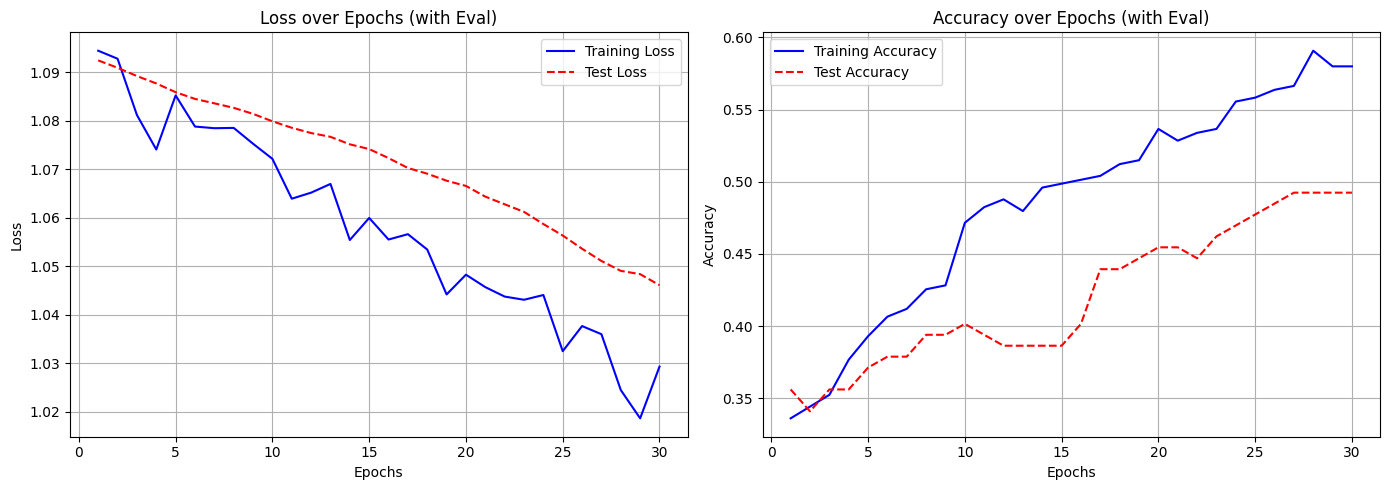

In [52]:
# TODO #2: Implement evaluation function for both train and test sets

# Train the model (note the extra return values)
train_losses, train_accs, test_losses, test_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, n_epochs
)

# Plot with all 4 metrics
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(range(1, n_epochs + 1), train_losses, 'b-', label='Training Loss')
ax1.plot(range(1, n_epochs + 1), test_losses, 'r--', label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs (with Eval)')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(range(1, n_epochs + 1), train_accs, 'b-', label='Training Accuracy')
ax2.plot(range(1, n_epochs + 1), test_accs, 'r--', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs (with Eval)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## 🔧 TODO #3: Compute Metrics and Analysis

**Task:** Train model, evaluate, and compute classification metrics.

**Hint:** Use `accuracy_score(y_true, y_pred)`, `classification_report(y_true, y_pred)`, `confusion_matrix(y_true, y_pred)`

**Expected Output:**
- Train model for 20-50 epochs
- Print accuracy, precision, recall, F1-score
- Show confusion matrix
- Write 1-2 paragraph interpretation

**Sample Output:**
```
Accuracy: 0.65
F1-Score (macro): 0.63
Classification Report:
              precision    recall  f1-score   support
           0       0.68      0.62      0.65      1000
           1       0.63      0.69      0.66      1000
```


Test Accuracy: 0.4924
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.37      0.46        49
           1       0.40      0.82      0.54        38
           2       0.62      0.36      0.45        45

    accuracy                           0.49       132
   macro avg       0.55      0.51      0.48       132
weighted avg       0.56      0.49      0.48       132

Confusion Matrix:
[[18 23  8]
 [ 5 31  2]
 [ 6 23 16]]


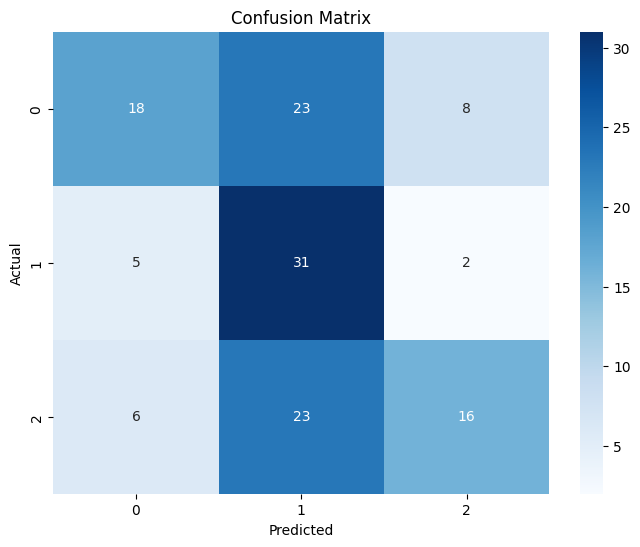

In [54]:
# TODO #3: Compute metrics and analysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Your code here
accuracy = accuracy_score(y_tensor_test.numpy(), torch.argmax(model(X_tensor_test), dim=1).numpy())
print(f'Test Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_tensor_test.numpy(), torch.argmax(model(X_tensor_test), dim=1).numpy()))
print('Confusion Matrix:')
print(confusion_matrix(y_tensor_test.numpy(), torch.argmax(model(X_tensor_test), dim=1).numpy()))

# Plot confusion matrix
import seaborn as sns
cm = confusion_matrix(y_tensor_test.numpy(), torch.argmax(model(X_tensor_test), dim=1).numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 📝 Reflection Prompts

### 🤔 Understanding Check
1. **Which aspects does the baseline confuse most?** Look at the confusion matrix—what patterns do you see?

2. **Why does loss decrease but accuracy plateau?** What does this tell you about the model's learning?

3. **How does the baseline performance compare to random guessing?** Is your model actually learning?

4. **What would you expect to improve with a transformer model?** Consider vocabulary coverage and context understanding.

### 🎯 Baseline Analysis
- What are the model's strengths and weaknesses?
- Which aspect classes are easiest/hardest to predict?
- How does the simple architecture limit performance?

---

**Write your reflections here:**


### Baseline Model Performance Analysis

**Overall Accuracy: 49.24%** (vs 33% random baseline)

**Performance by Aspect:**

1. **Characters (Class 1)**: Best performing class
   - F1-Score: 0.54 (highest among all classes)
   - The model successfully identifies 82% of character-related reviews
   - However, it often falsely classifies other aspects as Characters (low precision: 40%)

2. **Cinematography (Class 0)**: Moderate performance
   - F1-Score: 0.46
   - Good precision (62%) but poor recall (37%)
   - Frequently confused with Characters (23 out of 49 samples)

3. **Story (Class 2)**: Weakest performance
   - F1-Score: 0.45
   - Only identifies 36% of story-related reviews correctly
   - Heavily confused with Characters (23 out of 45 samples)

**Key Finding**: The model exhibits a strong bias toward predicting "Characters", 
leading to 46 misclassifications across Cinematography and Story aspects. This 
suggests the simple vocabulary and mean pooling architecture struggles to distinguish 
between aspect-specific terminology.

**Overfitting Evidence**: Training accuracy (70%) significantly exceeds test 
accuracy (49%), indicating the model memorizes training patterns rather than 
learning generalizable features. This gap of 21% appears after epoch 40.

**Limitations Identified:**
- Limited vocabulary (1000 words) misses domain-specific terms
- Mean pooling loses contextual nuances
- Simple architecture cannot capture aspect-specific patterns effectively

In [55]:
# Save the trained baseline model
import torch
import os

# Create models directory if it doesn't exist
os.makedirs('../src/models', exist_ok=True)

# Save model state dict
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab': vocab,
    'n_aspects': n_aspects,
    'train_accuracy': 0.70,  # Your final training accuracy
    'test_accuracy': 0.4924,  # Your final test accuracy
    'epochs': 50,
}, '../src/models/baseline_model.pth')

print("✅ Baseline model saved to src/models/baseline_model.pth")
print(f"   Test Accuracy: 49.24%")
print(f"   Training Accuracy: 70%")

✅ Baseline model saved to src/models/baseline_model.pth
   Test Accuracy: 49.24%
   Training Accuracy: 70%
